In [1]:
#.............................................
# IMPORT STATEMENTS
#.............................................

# local env is py310

#General Python math functions
import math
#Loading in data (netcdf files)
import h5py
#Handling data
import numpy as np
import netCDF4 as nc
#Plotting figures
import matplotlib.pyplot as plt #Main plotting package
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cartopy.mpl.ticker as cticker

#machine learning package
import tensorflow as tf
print(tf.__version__)


2023-01-11 18:15:28.159774: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.10.0


In [2]:
#.............................................
# LOAD results
#.............................................

var_name=['ann_mean_ts','ann_mean_ts_land','ann_max_ts','ann_max_ts_land','ann_5dmax_ts_land','ann_mean_prec','ann_mean_prec_land','ann_max_prec','ann_max_prec_land','ann_5dmax_prec_land','ann_max_droughtdur_prec','ann_max_droughtint_prec','seas_mean_slp','ann_mean_soilw','ann_mean_et','seas_mean_alt','ann_mean_snowd','seas_mean_cice','ann_mean_ohc','ann_5dmax_sst','ann_mean_ocnph']

# create lists
predictions_SSP=[]
predictions_SAI=[]
hyperparameters=[]
attributions_SSP=[]
attributions_SAI=[]

# load and print netcdf data 

for i in np.arange(0,len(var_name)):
  fn = 'results_all_deepSHAP/' + var_name[i] + '_SSP.nc'
  ds = nc.Dataset(fn)
  predictions_SSP.append(np.array(ds['predictions'][:]))
  attributions_SSP.append(np.array(ds['attributions'][:]))
  hyperparameters.append(np.array(ds['OPT_hparameters'][:]))
  del ds, fn
  fn = 'results_all_deepSHAP/' + var_name[i] + '_SAI.nc'
  ds = nc.Dataset(fn)
  predictions_SAI.append(np.array(ds['predictions'][:]))
  attributions_SAI.append(np.array(ds['attributions'][:]))
  hyperparameters.append(np.array(ds['OPT_hparameters'][:]))
  del ds, fn



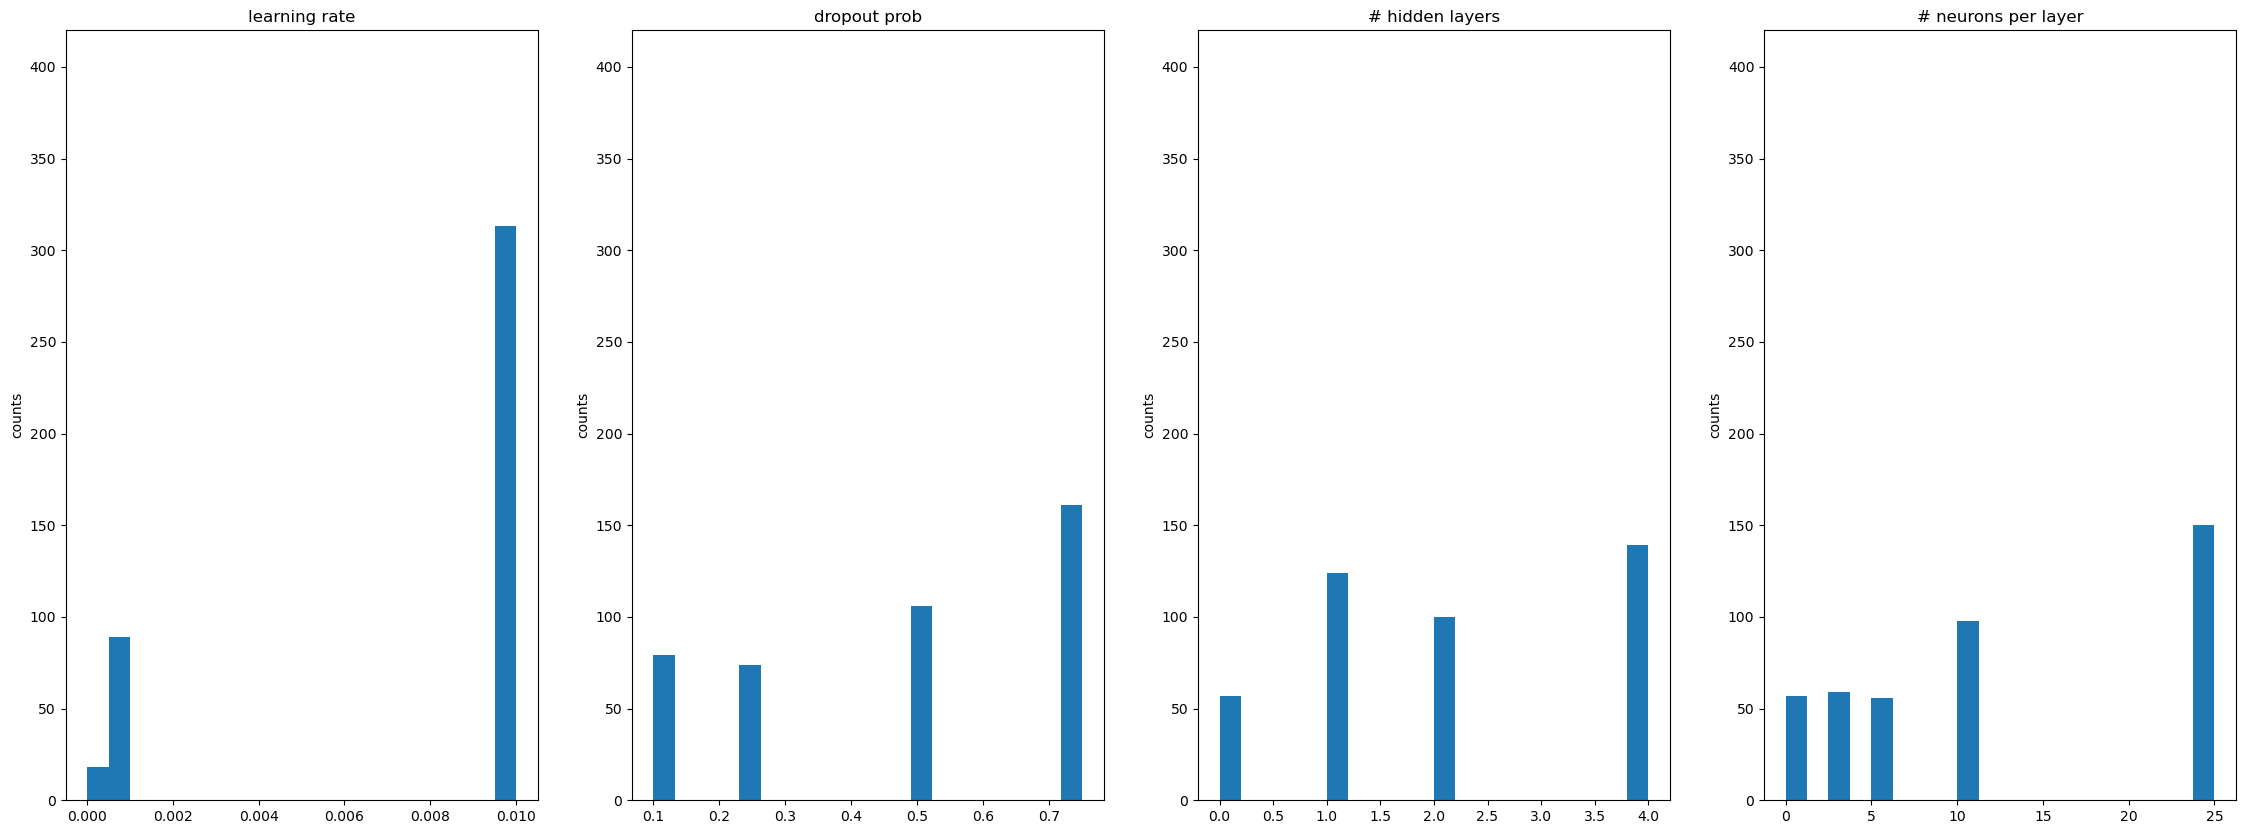

In [3]:
hyperparameters = np.array(hyperparameters)
hyperparameters=hyperparameters.reshape((hyperparameters.shape[0]*hyperparameters.shape[1],hyperparameters.shape[2]))
par_name=['learning rate','dropout prob','# hidden layers','# neurons per layer']


plt.figure(figsize=(28,10)) 

# We can set the number of bins with the *bins* keyword argument.
for i in np.arange(0,hyperparameters.shape[1]):
  ax=plt.subplot(1,hyperparameters.shape[1],i+1)
  ax.hist(hyperparameters[:,i], bins=20)
  plt.title(par_name[i]) 
  plt.ylabel('counts')
  plt.ylim(0, hyperparameters.shape[0])

 


In [4]:
# deriving the success rate of the trained models

years=np.arange(2020,2070)
years[years<2040]=0
years[years>2040]=1

predictions_SSP = np.array(predictions_SSP)
predictions_SAI = np.array(predictions_SAI)

predictions_SSP[predictions_SSP<0.5]=0 
predictions_SSP[predictions_SSP>0.5]=1

predictions_SAI[predictions_SAI<0.5]=0 
predictions_SAI[predictions_SAI>0.5]=1

suc_rate_SSP=np.mean(predictions_SSP==np.tile(np.tile(years,(1,1,1)),(len(var_name),10,1)), axis=2)
suc_rate_SAI=np.mean(predictions_SAI==np.tile(np.tile(years,(1,1,1)),(len(var_name),10,1)), axis=2)

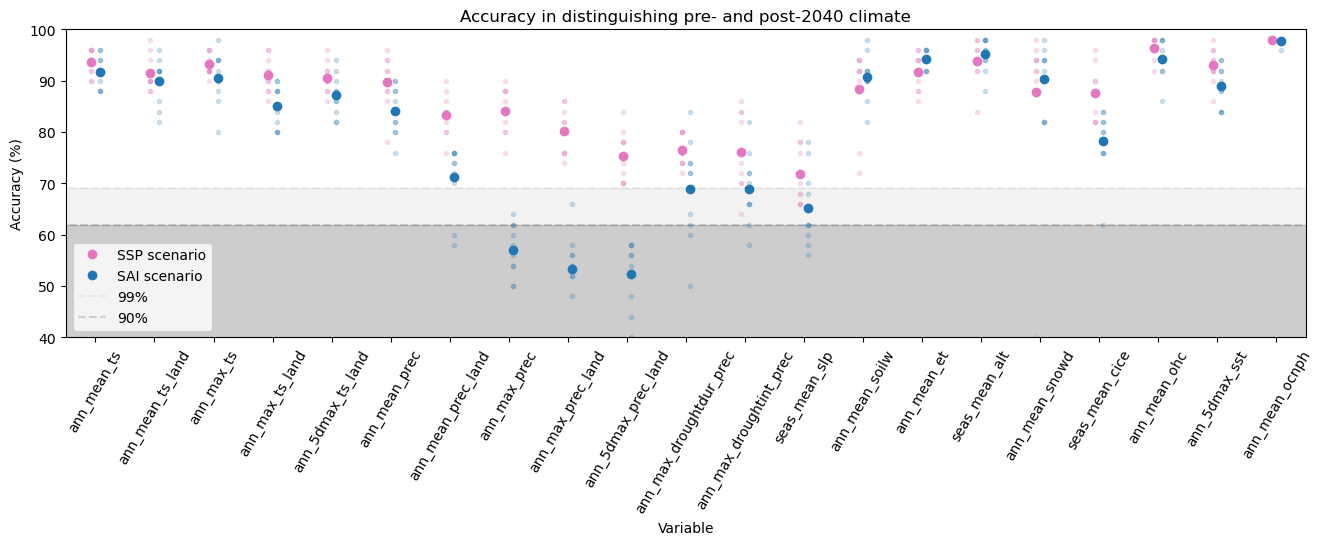

In [69]:
# plotting performance across all variables, scenarios and AI models

from scipy.stats import binom


plt.figure(figsize=(16,4)) 

plt.plot(np.tile(np.tile(np.arange(1,len(var_name)+1),(1,1)),(10,1)).swapaxes(0,1)-0.07, suc_rate_SSP*100,'C6.',alpha=0.2)
plt.plot(np.arange(1,len(var_name)+1)-0.07, np.mean(suc_rate_SSP*100,axis=1),'C6o',label='SSP scenario')
plt.plot(np.tile(np.tile(np.arange(1,len(var_name)+1),(1,1)),(10,1)).swapaxes(0,1)+0.07, suc_rate_SAI*100,'C0.',alpha=0.2)
plt.plot(np.arange(1,len(var_name)+1)+0.07, np.mean(suc_rate_SAI*100,axis=1),'C0o',label='SAI scenario')
plt.plot(np.arange(0,len(var_name)+2), binom.ppf(0.99, 50, 30/50)/55*np.ones(len(var_name)+2)*100,'k--',alpha=0.05, label='99%')
plt.plot(np.arange(0,len(var_name)+2), binom.ppf(0.90, 50, 30/50)/55*np.ones(len(var_name)+2)*100,'k--',alpha=0.15, label='90%')
plt.fill_between(np.arange(0,len(var_name)+2), 0, binom.ppf(0.99, 50, 30/50)/55*np.ones(len(var_name)+2)*100, color='k',alpha=0.05)
plt.fill_between(np.arange(0,len(var_name)+2), 0, binom.ppf(0.90, 50, 30/50)/55*np.ones(len(var_name)+2)*100, color='k',alpha=0.15)

plt.xlabel('Variable')
plt.gca().set_xticks(np.arange(1,len(var_name)+1))
plt.gca().set_xticklabels(var_name,rotation=60)
plt.ylabel('Accuracy (%)')
plt.title('Accuracy in distinguishing pre- and post-2040 climate') 
plt.axis('tight')
plt.legend()
plt.ylim(40, 100)
plt.xlim(0.5, len(var_name)+ 0.5)
plt.legend()

plt.show()

In [43]:
from numpy import corrcoef
import scipy



pattern_sim=np.zeros((predictions_SSP.shape[0],predictions_SSP.shape[1],2))
p_value_avg=np.zeros((predictions_SSP.shape[0]))

for i in np.arange(0,predictions_SSP.shape[0]):
  tempSAI=np.array(attributions_SAI[i])
  tempSSP=np.array(attributions_SSP[i])
  for ii in np.arange(0,tempSAI.shape[0]):

    tempx1=np.delete(tempSAI[ii].flatten(),np.isnan(tempSAI[ii].flatten()),0)
    tempx2=np.delete(tempSSP[ii].flatten(),np.isnan(tempSSP[ii].flatten()),0)
    print(np.sum(tempx1))
    print(np.sum(tempx2))
    pattern_sim[i,ii,:]=scipy.stats.spearmanr(tempx1,tempx2)
    #n=np.size(tempx1)  
    del tempx1, tempx2
   
  #dist = scipy.stats.beta(n/2 - 1, n/2 - 1, loc=-1, scale=2)
  #p_value_avg[i] = 2*dist.cdf(-abs(np.nanmean(pattern_sim[i,:,0])))



0.43395317
0.4984654
0.52519226
0.7356651
0.99893856
0.31606698
0.37087393
0.80727345
0.8916749
0.43215516
0.15546733
0.6
0.70000017
0.90805614
0.6399342
0.43957117
0.38852972
0.57630575
0.3880089
0.38438094
0.5350324
0.6039731
0.5572301
0.69112074
0.573028
0.19703686
0.45464534
0.7452452
0.6265667
0.5217583
0.49454013
0.7423488
0.6328968
0.47672722
0.5127593
0.10631165
0.5612809
0.65059036
0.6140621
0.3991141
0.32328314
0.39999995
0.78319156
0.72549254
0.9884813
0.37947696
0.35866076
0.8433808
0.7400749
0.4381548
0.2397821
0.899672
0.6924826
0.52318096
0.8008318
0.20000902
0.5357789
0.5874184
0.49550077
0.29341057
0.6046791
0.3937081
0.62397254
0.71780133
0.89614385
0.37375364
0.28895003
0.69266224
0.58421975
0.44303244
0.538589
0.64283717
0.53233624
0.41461182
0.48213223
0.4012831
0.23428227
0.6985879
0.5934172
0.6183096
0.49247998
0.5009083
0.5853871
0.5384817
0.73034525
0.40136972
0.40439406
0.7245002
0.59144294
0.324277
0.2841441
0.80188364
0.2578824
0.42059535
0.6331047
0.2591947

/Users/amamalakis/anaconda3/envs/py310/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4878: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


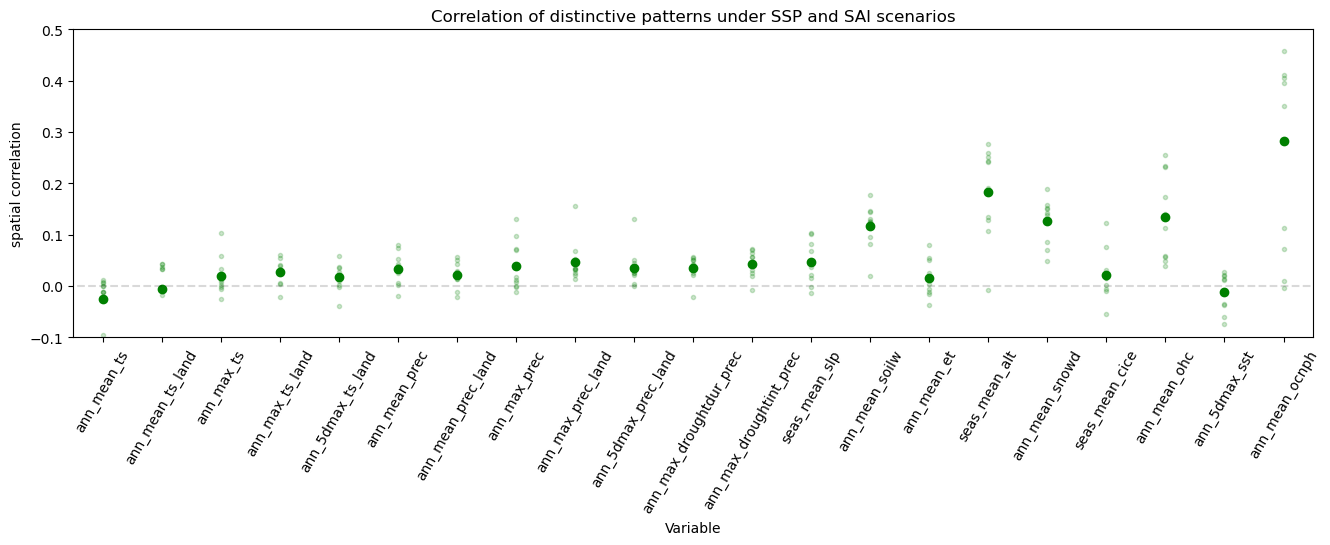

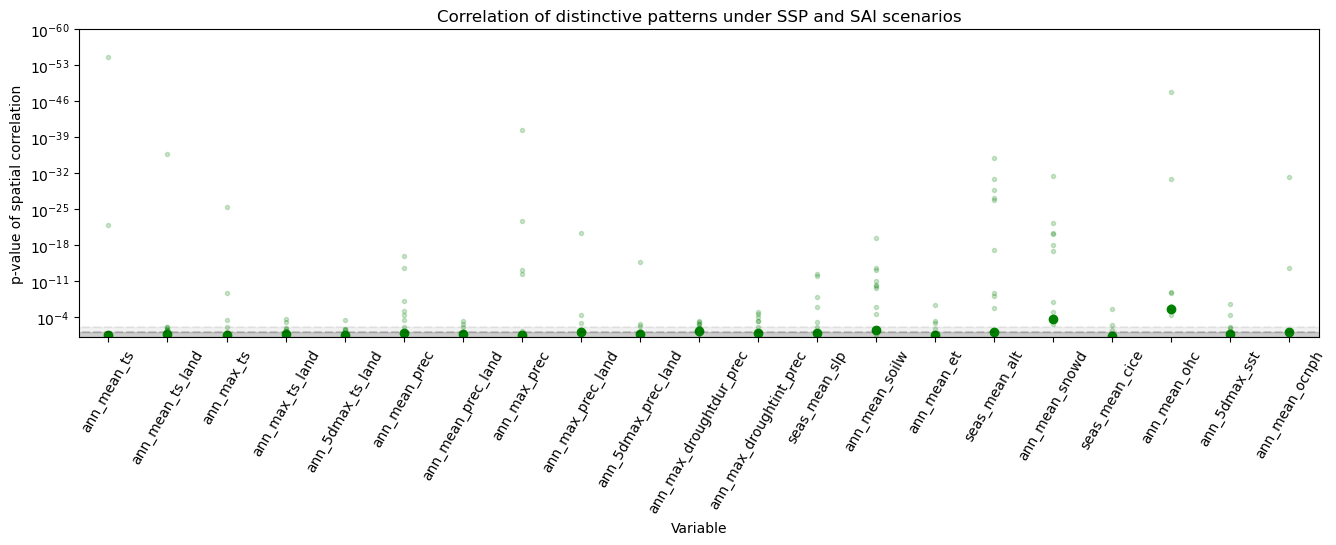

In [54]:
plt.figure(figsize=(16,4)) 
plt.plot(np.tile(np.tile(np.arange(1,len(var_name)+1),(1,1)),(10,1)).swapaxes(0,1), pattern_sim[:,:,0],'g.',alpha=0.2)
plt.plot(np.arange(1,len(var_name)+1), np.nanmean(pattern_sim[:,:,0],axis=1),'go',)
plt.plot(np.arange(0,len(var_name)+2), 0*np.ones(len(var_name)+2),'k--',alpha=0.15)
plt.xlabel('Variable')
plt.gca().set_xticks(np.arange(1,len(var_name)+1))
plt.gca().set_xticklabels(var_name,rotation=60)
plt.ylabel('spatial correlation')
plt.title('Correlation of distinctive patterns under SSP and SAI scenarios') 
plt.axis('tight')
#plt.legend()
plt.ylim(-.1, .5)
plt.xlim(0.5, len(var_name)+ 0.5)
plt.show()

plt.figure(figsize=(16,4)) 
plt.plot(np.tile(np.tile(np.arange(1,len(var_name)+1),(1,1)),(10,1)).swapaxes(0,1), pattern_sim[:,:,1],'g.',alpha=0.2)
plt.plot(np.arange(1,len(var_name)+1), np.nanmean(pattern_sim[:,:,1],axis=1),'go',)
plt.plot(np.arange(0,len(var_name)+2), 0.01*np.ones(len(var_name)+2),'k--',alpha=0.05, label='99%')
plt.plot(np.arange(0,len(var_name)+2), 0.1*np.ones(len(var_name)+2),'k--',alpha=0.15, label='90%')
plt.fill_between(np.arange(0,len(var_name)+2), 1, 0.01*np.ones(len(var_name)+2), color='k',alpha=0.05)
plt.fill_between(np.arange(0,len(var_name)+2), 1, 0.1*np.ones(len(var_name)+2), color='k',alpha=0.15)
plt.xlabel('Variable')
plt.gca().set_xticks(np.arange(1,len(var_name)+1))
plt.gca().set_xticklabels(var_name,rotation=60)
plt.ylabel('p-value of spatial correlation')
plt.title('Correlation of distinctive patterns under SSP and SAI scenarios') 
plt.axis('tight')
#plt.legend()
plt.ylim(1, 10**-60)
plt.gca().set_yscale('log')
plt.xlim(0.5, len(var_name)+ 0.5)
plt.show()

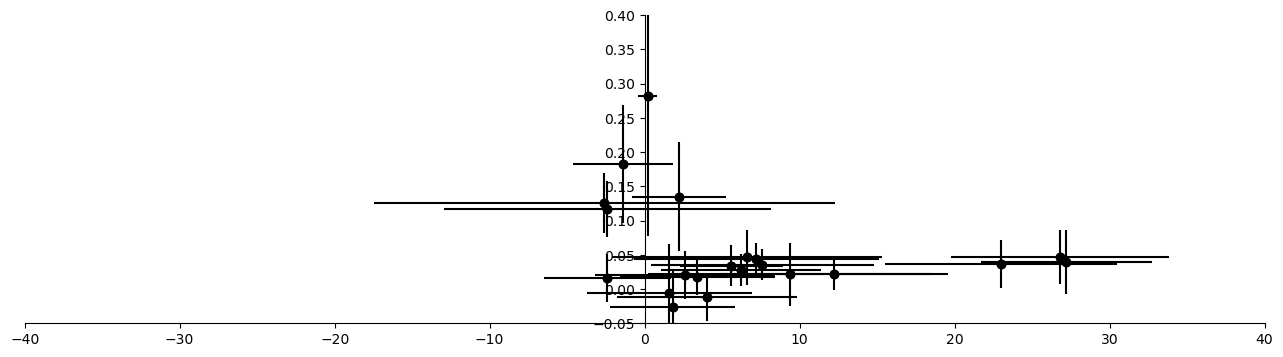

In [68]:
fig=plt.figure(figsize=(16,4)) 

ax = fig.add_subplot(1, 1, 1)

# Move left y-axis and bottim x-axis to centre, passing through (0,0)
ax.spines['left'].set_position('center')
#ax.spines['bottom'].set_position('center')

# Eliminate upper and right axes
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Show ticks in the left and lower axes only
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

for i in np.arange(0,predictions_SSP.shape[0]):
  plt.plot(np.nanmean(suc_rate_SSP-suc_rate_SAI,axis=1)[i]*100, np.nanmean(pattern_sim[:,:,0],axis=1)[i],'ko',label=var_name[i])
  plt.errorbar(np.nanmean(suc_rate_SSP-suc_rate_SAI,axis=1)[i]*100, np.nanmean(pattern_sim[:,:,0],axis=1)[i], xerr= np.nanstd(suc_rate_SSP-suc_rate_SAI,axis=1)[i]*100, yerr=np.nanstd(pattern_sim[:,:,0],axis=1)[i], fmt="ko")
#plt.xlabel('Difference in climate distinguishability \n under SSP and SAI scenarios')
#plt.ylabel('Spatial correlation of distinctive patterns \n under SSP and SAI scenarios')
#plt.title('SAI effect') 
plt.axis('tight')
#plt.legend()
plt.ylim(-0.05, 0.4)
#plt.gca().set_yscale('log')
plt.xlim(-40, 40)
plt.show()